# SVHN Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. 

In [2]:
import os
import sys
import tarfile
import cPickle
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

### Extracting the dataset

After <a href="http://ufldl.stanford.edu/housenumbers/">downloading</a> we need to extract the tarballs.

In [3]:
# Get the directory listing for the dataset folder
data = [f for f in os.listdir("data") if 'tar.gz' in f]

print("Files", data)

('Files', ['extra.tar.gz', 'test.tar.gz', 'train.tar.gz'])


In [4]:
def extract_tarball(fname, force=False):
    """Extract a tarball if not already extracted"""
    root = fname.split('.')[0] # Drop file extension
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, fname))
        return
    if (fname.endswith("tar.gz")):
        print("Extracting %s ..." % fname)
        tar = tarfile.open(fname, "r:gz")
        tar.extractall()
        tar.close()

In [5]:
# Change working directory
os.chdir("data")

# Extract all the files
for f in data:
    extract_tarball(f)
    
# Lets move on up
os.chdir(os.path.pardir)

extra already present - Skipping extraction of extra.tar.gz.
test already present - Skipping extraction of test.tar.gz.
train already present - Skipping extraction of train.tar.gz.


Lets take a look at the images to see what we are dealing with.

### Training set

The digitStruct.mat file contains a struct called digitStruct with the same length as the number of original images. Each element in digitStruct has the following fields: name which is a string containing the filename of the corresponding image. bbox which is a struct array that contains the position, size and label of each digit bounding box in the image. Extracting the bounding boxes turned out to be more challenging than first expected. The code for unwrapping the digitStruct files can be found in *unpacker.py*

In [11]:
from unpacker import DigitStructWrapper

def get_size(start_path = '.'):
    """Get the total size in MB of all files in a directory"""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / 1000000.0

def display_stats(start_path = '.'):
    """Displays and returns the number of files in a folder and the total file size"""
    num_files = len(os.listdir(start_path))
    size = get_size(start_path)
    print("Number of files", num_files, "Size in MB", size)
    return size, num_files 

def get_bounding_boxes(start_path = '.'):
    """Return the bounding boxes for all """
    return DigitStructWrapper(start_path).unpack_all()

In [12]:
from IPython.display import display, Image, HTML

def display_images(folder, num_images):
    """Display sample images from a folder using HTML"""
    html_string, files = '', os.listdir(folder)[:num_images]
    for i, f in enumerate(files, 1):
        # Pick the first picture in every folder
        path = os.path.join(folder, f)
        # Append picture as a HTML string
        html_string += "<img style='width: 200px; margin: 5px; float: left; border: 1px solid black;' src='%s' />" % str(path)
        if i % 4 == 0 and i != 0:
            html_string += "<br clear='all'/>"
    # Display images using HTML
    display(HTML(html_string))
    
train_stats = display_stats("data/train")  
display_images("data/train", 8)

('Number of files', 33404, 'Size in MB', 626.161412)


In [13]:
# Extract the bounding boxes for the training set
train_bbox = get_bounding_boxes('data/train/digitStruct.mat')

train_bbox[1]

{'boxes': [{'height': 32.0,
   'label': 2.0,
   'left': 77.0,
   'top': 29.0,
   'width': 23.0},
  {'height': 32.0, 'label': 3.0, 'left': 98.0, 'top': 25.0, 'width': 26.0}],
 'filename': '2.png'}

### Test set

In [52]:
test_stats = display_stats("data/test")  
display_images("data/test", 8)

('Number of files', 13070, 'Size in MB', 356.832724)


In [ ]:
# Extract the bounding boxes for the test set
test_bbox = get_bounding_boxes('data/test/digitStruct.mat')

test_bbox[0]

### Extras

In [53]:
extra_stats = display_stats("data/extra")
display_images("data/extra", 8)

('Number of files', 202355, 'Size in MB', 3504.414984)


In [ ]:
# Extract the bounding boxes for the extra set
extra_bbox = get_bounding_boxes('data/extra/digitStruct.mat')

extra_bbox[0]

### Initial Observations

From looking at the pictures we can make the following observations:

* The picture seem to only contain one number
* The images and numbers come in different shapes, forms and sizes
* There are multiple different fonts in the pictures
* The distances between the various digits vary
* Some of the numbers are rotated while other are skewed

The recognition problem is further complicated by environmental factors such as lighting, shadows, specularities, and occlusions as well as by image acquisition factors such as resolution, motion, and focus blurs. 

### Bounding Boxes

Let's write a simple function that displays the image and it's bounding boxes.

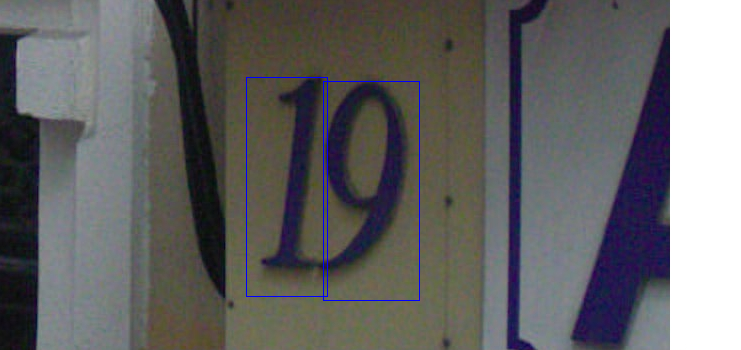

In [34]:
from PIL import Image, ImageDraw

def display_bbox(img, boxes):
    im = Image.open(img)
    draw = ImageDraw.Draw(im)
    for bbox in boxes['boxes']:
        rectangle = ((bbox['left'], bbox['top']), (bbox['left'] + bbox['width'],bbox['top'] + bbox['height']))
        draw.rectangle(rectangle, outline = "blue")
    return im
    
display_bbox("data/train/1.png", train_bbox[0])

## Basic Preprocessing

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

* Scale the images down to 32x32 pixels
* Remove all images with more than 5 digits
* Create a more elaborate datastructure for our labels
* Store the data in a more accessible format

### Removing images with more than 5 digits

### Improving the label datastructure

### Storing the data